In [1]:
import pandas as pd
df = pd.read_csv('~/Desktop/Datasets/2020-Jan.csv', header = 'infer', 
                parse_dates = ['event_time'], 
                 date_parser = pd.to_datetime, nrows=300000)

# RQ6

1. Find the overall conversion rate of your store.

In [2]:
# Creating subsets

views = df[df.event_type == 'view']
purchases = df[df.event_type == 'purchase']

In [3]:
# Conversion rate = number of purchases / number of views

CR = purchases['product_id'].count() / views['product_id'].count()
print('The overall conversion rate is:', round(CR,3))

The overall conversion rate is: 0.098


2. Plot the number of purchases of each category and show the conversion rate of each category in decreasing order.

Method 1

In [4]:
# Finding categories

df['category_code'].unique()

array([nan, 'accessories.bag', 'stationery.cartrige',
       'appliances.environment.vacuum', 'apparel.glove',
       'appliances.personal.hair_cutter', 'furniture.living_room.cabinet',
       'accessories.cosmetic_bag', 'furniture.bathroom.bath',
       'appliances.environment.air_conditioner'], dtype=object)

In [5]:
df['category_id'].nunique()

418

The general categories are at the beginning of these strings (e.g. in `accessories.bag` we only need `accessories`), so we need to extract the category names

In [6]:
# Adjusting categories 

def fun(x):
    return str(x).split('.')[0]

df["category"]=df["category_code"].apply(fun)

In [7]:
df['category'].unique()

array(['nan', 'accessories', 'stationery', 'appliances', 'apparel',
       'furniture'], dtype=object)

In [8]:
# Now we create again the subsets to include the new column ONLY NOT NAN

df_notNan = df[df.category != 'nan']
views_notNan = df_notNan[df_notNan.event_type == 'view']
purchases_notNan = df_notNan[df_notNan.event_type == 'purchase']

In [9]:
df_notNan['category'].unique()

array(['accessories', 'stationery', 'appliances', 'apparel', 'furniture'],
      dtype=object)

In [10]:
# Finding number of purchases for each category

d1 = purchases_notNan.groupby('category').event_type.count().reset_index().rename(columns =
                                                    {'event_type':'purchases_number'})
d1

,category,purchases_number
0,accessories,6
1,apparel,67
2,appliances,51
3,furniture,18
4,stationery,65


In [11]:
# Finding number of views for each category

d2 = views_notNan.groupby('category').event_type.count().reset_index().rename(columns =
                                                    {'event_type':'views_number'})

In [12]:
# Joining dataframes in order to have the number of purchases and views for each category

dout = d1.merge(d2, on = 'category')
dout

,category,purchases_number,views_number
0,accessories,6,347
1,apparel,67,320
2,appliances,51,1841
3,furniture,18,501
4,stationery,65,243


In [13]:
# Adding a third column that is a combination of the other two in order to find the c.r.

dout['conversion_rate'] = dout.apply(lambda row: 
                                     row.purchases_number / row.views_number, axis=1)

I'm assuming that the purchase rate is the number of purchases for each category. 

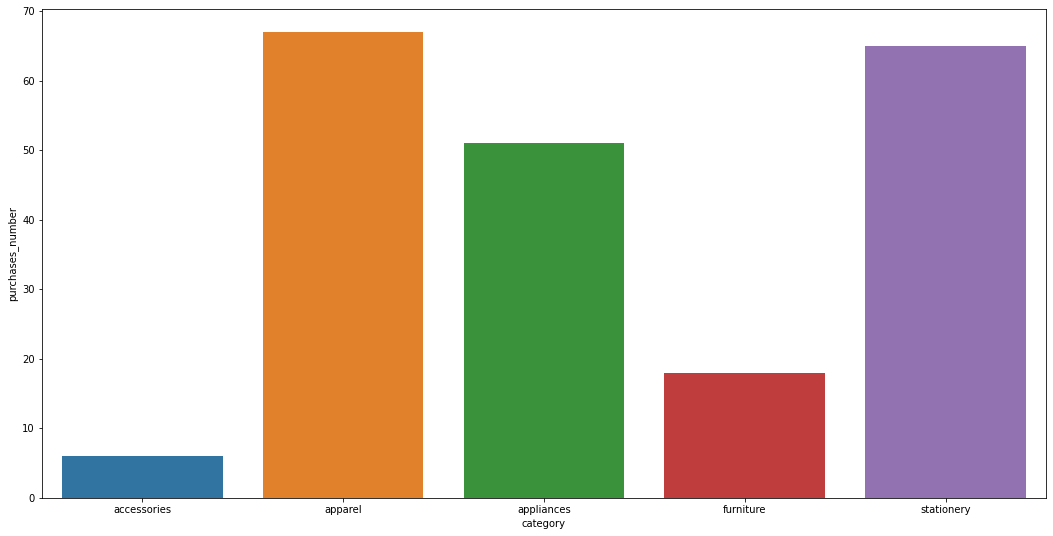

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,9))
plot = sns.barplot(x='category', y='purchases_number', data=dout)

In [15]:
# Sorting values

dout.sort_values(by='conversion_rate', ascending = False)

,category,purchases_number,views_number,conversion_rate
4,stationery,65,243,0.267490
1,apparel,67,320,0.209375
3,furniture,18,501,0.035928
2,appliances,51,1841,0.027702
0,accessories,6,347,0.017291


Method 2

In [16]:
d3 = purchases.groupby('category_id').event_type.count().reset_index().rename(columns =
                                                    {'event_type':'purchases_number'})
d4 = views.groupby('category_id').event_type.count().reset_index().rename(columns =
                                                    {'event_type':'views_number'})
dout_ext = d3.merge(d4, on = 'category_id')
dout_ext.head(1)

,category_id,purchases_number,views_number
0,1487580004832248652,13,367


In [17]:
# Adding a third column that is a combination of the other two in order to find the c.r.

dout_ext['conversion_rate'] = dout_ext.apply(lambda row: 
                                     row.purchases_number / row.views_number, axis=1)
dout_ext.head(1)

,category_id,purchases_number,views_number,conversion_rate
0,1487580004832248652,13,367,0.035422


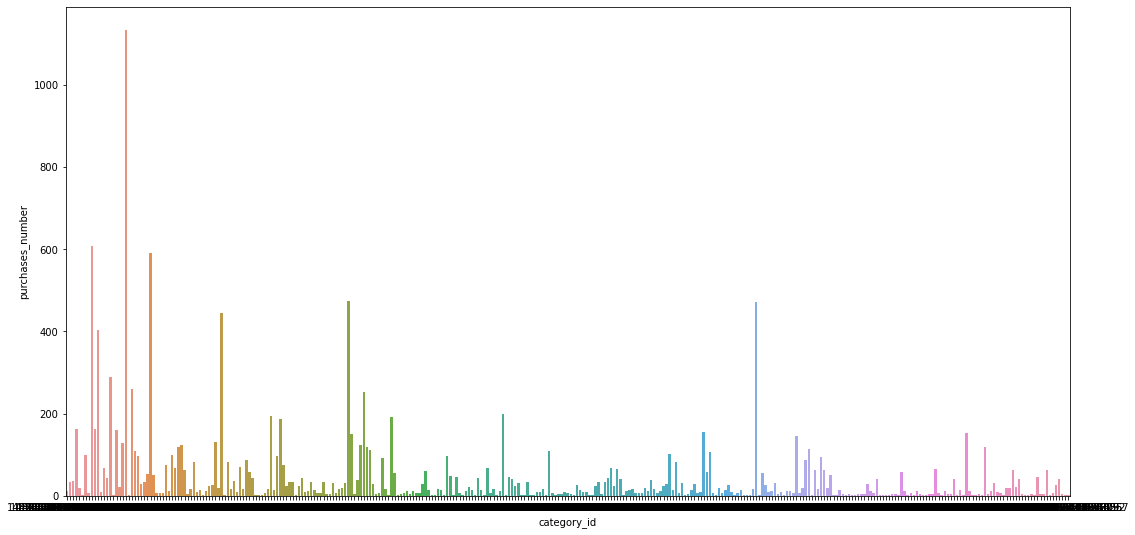

In [18]:
#NEED TO CANCEL THE CATEGORY LABELS

import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,9))
plot = sns.barplot(x='category_id', y='purchases_number', data=dout_ext)

# RQ7

1. The Pareto principle states that for many outcomes roughly 80% of consequences come from 20% of the causes. Also known as 80/20 rule, in e-commerce simply means that most of your business, around 80%, likely comes from about 20% of your customers. Prove that the pareto principle applies to your store.


In [19]:
# Grouping customers and computing total revenue (amount of money spent) for each one 

customers = df.groupby('user_id').price.sum().to_frame('total_revenue').sort_values(
    by='total_revenue', ascending = False).reset_index()
customers

,user_id,total_revenue
0,373989853,136623.61
1,568233448,19152.54
2,523985247,6795.37
3,571953566,5764.92
4,595861471,5093.23
...,...,...
38921,595809918,0.00
38922,595471775,0.00
38923,595531690,0.00
38924,596496918,0.00


In [20]:
# Adding column with cumulative sum : cumul_sum[i] = cumul_sum[i-i] 

revenue = customers['total_revenue'].sum()
customers['cumul_sum'] = customers['total_revenue'].cumsum()
customers

,user_id,total_revenue,cumul_sum
0,373989853,136623.61,136623.61
1,568233448,19152.54,155776.15
2,523985247,6795.37,162571.52
3,571953566,5764.92,168336.44
4,595861471,5093.23,173429.67
...,...,...,...
38921,595809918,0.00,2864219.77
38922,595471775,0.00,2864219.77
38923,595531690,0.00,2864219.77
38924,596496918,0.00,2864219.77


In [21]:
# Adding column with the percentage of the cumulative sum over the store revenue 

customers['percent_cumul_sum'] = customers.apply(lambda row: 
                                     round(row.cumul_sum / revenue,4)*100, axis=1)
customers.head()

,user_id,total_revenue,cumul_sum,percent_cumul_sum
0,373989853,136623.61,136623.61,4.77
1,568233448,19152.54,155776.15,5.44
2,523985247,6795.37,162571.52,5.68
3,571953566,5764.92,168336.44,5.88
4,595861471,5093.23,173429.67,6.06


In [40]:
pareto_index = customers[customers['percent_cumul_sum'] >= 80].index[0]
print('The', round((pareto_index/len(customers)),3)*100,'percent of the users provides approximately the 80 percent of the store revenue.')

The 19.8 percent of the users provides approximately the 80 percent of the store revenue.


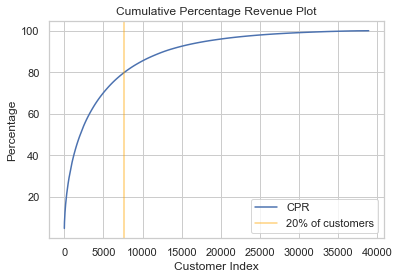

In [56]:
customers['percent_cumul_sum'].plot(label='CPR')
plt.figsize = (25,7)
plt.title('Cumulative Percentage Revenue Plot')
plt.ylabel('Percentage')
plt.xlabel('Customer Index')
plt.axvline(pareto_index, label='20% of customers',color='orange',alpha=0.5)
plt.legend()

plt.show()

# RQ1

1. What’s the operation users repeat more on average within a session? Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc).

In [57]:
df['event_type'].unique()

array(['view', 'cart', 'remove_from_cart', 'purchase'], dtype=object)

In [58]:
event_series = df.groupby('event_type').event_type.count().to_frame('number_of_events').reset_index()
event_series

,event_type,number_of_events
0,cart,80481
1,purchase,14120
2,remove_from_cart,60948
3,view,144451


In [59]:
df[df.event_type=='view'].nunique()

event_time       102361
event_type            1
product_id        22892
category_id         415
category_code         9
brand               232
price              1664
user_id           37371
user_session      64216
category              6
dtype: int64

In [60]:
n = df['user_session'].nunique()
event_series['avg_events'] = event_series.apply(lambda row: row.number_of_events /n, axis=1)
event_series

,event_type,number_of_events,avg_events
0,cart,80481,1.187053
1,purchase,14120,0.208263
2,remove_from_cart,60948,0.898951
3,view,144451,2.130577


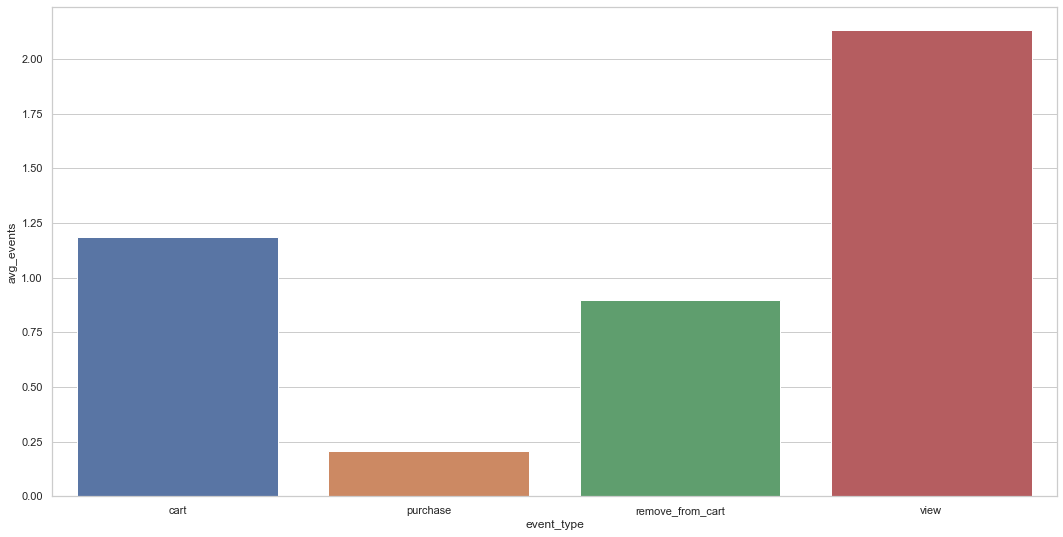

In [62]:
fig = plt.figure(figsize=(18,9))
plot = sns.barplot(x='event_type', y='avg_events', data=event_series)

2. How many times, on average, a user views a product before adding it to the cart?

In [79]:
nviews = int(event_series[event_series.event_type == 'view']['number_of_events'])
ncarts = int(event_series[event_series.event_type == 'cart']['number_of_events'])
print('On average, products are seen', round(nviews/ncarts,3),'times before they are added to the cart.')

On average, products are seen 1.795 times before they are added to the cart.


3. What’s the probability that products added once to the cart are effectively bought?

144451